### Imports

In [1]:
import os
import sys
import glob
import csv
import time
import platform
import socket
import random
from datetime import datetime
from tqdm.auto import tqdm
from typing import Tuple, List, Callable

c:\Users\Aidan\.conda\envs\py310_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from PIL import Image
import psutil  # For system resource monitoring
# import GPUtil  # For GPU information
import wandb

In [3]:
import torch
from torch import nn
import torch.optim as optim
from torchvision.io import decode_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

### Constants

In [4]:
from displacements import VectorFieldComposer, VECTOR_FIELDS

TILES_DIR = "../tiles"
# TILE_IMAGE_PATHS = glob.glob(os.path.join(TILES_DIR, "**/*.png"), recursive=True)
TILE_IMAGE_PATHS = glob.glob(os.path.join(TILES_DIR, "g*/**/*.png"), recursive=True) # Just the graphite images
MAX_TILES = 50000
NUM_TILES = min(MAX_TILES, len(TILE_IMAGE_PATHS))

TILE_SIZE = 256

# Dataset

In [5]:
class CustomDataset(Dataset):
    def __init__(self, variations_per_image: int = 10):
        self.variations_per_image = variations_per_image
    
    def __len__(self):
        return NUM_TILES * self.variations_per_image

    def __getitem__(self, index):
        # Indexes work like this:
        # [1_0, ..., n_0, 1_1, ..., n_1, 1_v, ..., n_v, ...]
        # [1  , ..., n  , n+1, ..., n+n, vn+1,..., vn+n,...]
        # Where n is the number of images
        # And v is the variation number
        
        # Get the image index
        path_index = index % NUM_TILES
        variation = index // self.variations_per_image

        # random.seed(variation)
        # VALIDATION
        random.seed(time.time())

        composer = VectorFieldComposer()
            
        available_fields = list(VECTOR_FIELDS.keys())
        num_fields = random.randint(1, 3)
        for _ in range(num_fields):
            field_type = random.choice(available_fields)
            composer.add_field(field_type, randomize=True)
        
        image = np.array(Image.open(TILE_IMAGE_PATHS[path_index], mode="r"))
        image2 = composer.apply_to_image(image)

        grid_X, grid_Y = np.meshgrid(np.linspace(-1, 1, TILE_SIZE), np.linspace(-1, 1, TILE_SIZE))
        dx, dy = composer.compute_combined_field(grid_X, grid_Y)

        # return image.astype(np.float32), dx.astype(np.float32)
        return np.array([image, image2]).astype(np.float32), np.array([dx, dy]).astype(np.float32)

In [6]:
VARIATIONS_PER_IMAGE = 10
EPOCHS = 10
BATCH_SIZE = 64
IMG_SIZE = TILE_SIZE
LEARNING_RATE = 0.0001
SAVE_FREQUENCY = 5

MODEL_FILE = "model2/tx7.pth"

In [7]:
validation_dataset = CustomDataset(VARIATIONS_PER_IMAGE)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE)

# Model

In [8]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [9]:
class ConvolutionBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1, inplace=True),
        )

        self.residual = nn.Sequential()
        if in_channels != out_channels:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        # i learned about this in class today! the timing in on point!
        return self.conv(x) + self.residual(x)

class MotionVectorRegressionNetwork(nn.Module):
    def __init__(self, input_images = 2):
        super().__init__()
        # Outputs an xy motion vector per pixel
        self.input_images = input_images
        self.vector_channels = 2

        self.convolution = nn.Sequential(
            ConvolutionBlock(input_images, 32, kernel_size=3), # input_images (2) -> 32 channels
            nn.MaxPool2d(kernel_size=2), # scales down by half

            ConvolutionBlock(32, 64, kernel_size=3), # 32 -> 64 channels
            nn.MaxPool2d(kernel_size=2), # scales down by half

            ConvolutionBlock(64, 128, kernel_size=3), # 64 -> 128 channels 
            ConvolutionBlock(128, 128, kernel_size=3), # 128 -> 128 channels
        ) 

        self.output = nn.Sequential(
            # scale back up
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), # 128 -> 64 channels
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), # 64 -> 32 channels
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, self.vector_channels, kernel_size=3, stride=1, padding=1), # 32 -> 2 channels
        )

    def forward(self, x):
        # print(x.shape)
        x = self.convolution(x)
        # print(x.shape)
        x = self.output(x)
        # print(x.shape)
        return x

model = MotionVectorRegressionNetwork(input_images=2).to(device)
print(model)

MotionVectorRegressionNetwork(
  (convolution): Sequential(
    (0): ConvolutionBlock(
      (conv): Sequential(
        (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
      )
      (residual): Sequential(
        (0): Conv2d(2, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ConvolutionBlock(
      (conv): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
      )
      (residual): Sequential(
        (0):

In [10]:
def custom_loss(predicted_vectors, target_vectors):
    # print(predicted_vectors.shape)
    # print(target_vectors.shape)
    l1_loss = nn.functional.l1_loss(predicted_vectors, target_vectors)

    # some extra leniency to the loss by checking the neighboring pixels
    # print(predicted_vectors.shape)
    x_dir = predicted_vectors[:, :, 1:]
    neighbor_x = predicted_vectors[:, :, :-1]

    y_dir = predicted_vectors[:, :, :, 1:]
    neighbor_y = predicted_vectors[:, :, :, :-1]

    diff_x = torch.abs(x_dir - neighbor_x)
    diff_y = torch.abs(y_dir - neighbor_y)

    # print(diff_x.shape)
    # print(diff_y.shape)
    diff_x = diff_x.mean()
    # print(diff_x)
    diff_y = diff_y.mean()

    smoothening_value = diff_x + diff_y
    # print(smoothening_value)
    return l1_loss
    # return l1_loss + 0.1 * smoothening_value

In [11]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=5)

# Testing

In [12]:
# testin gthe model
model = MotionVectorRegressionNetwork().to(device)
model.load_state_dict(torch.load(MODEL_FILE, weights_only=True))

<All keys matched successfully>

1
torch.Size([64, 2, 256, 256]) torch.Size([64, 2, 256, 256]) torch.Size([64, 2, 256, 256])
(256, 256)
Converted Y Min:  -1.4879915714263916  Max:  1.483056128025055
Converted Pred Min:  -1.5507099628448486  Max:  1.2985687851905823
0 255


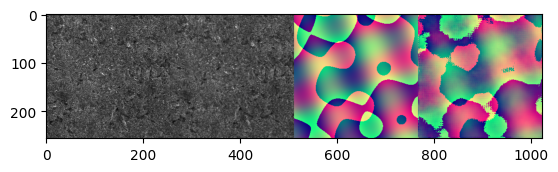

2
torch.Size([64, 2, 256, 256]) torch.Size([64, 2, 256, 256]) torch.Size([64, 2, 256, 256])
(256, 256)
Converted Y Min:  -0.39063912630081177  Max:  1.2278137803077698
Converted Pred Min:  -0.5318496227264404  Max:  1.1667701601982117
0 255


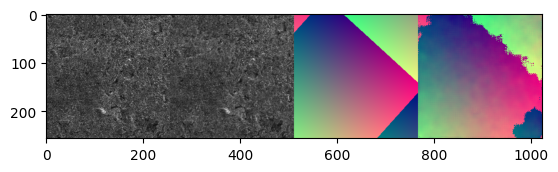

3
torch.Size([64, 2, 256, 256]) torch.Size([64, 2, 256, 256]) torch.Size([64, 2, 256, 256])
(256, 256)
Converted Y Min:  0.2364884316921234  Max:  1.0
Converted Pred Min:  0.13493147492408752  Max:  1.1080571413040161
0 255


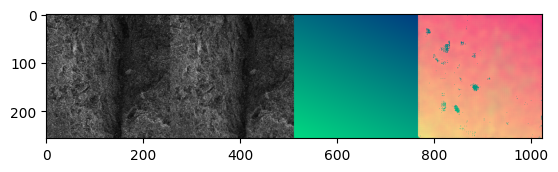

4
torch.Size([64, 2, 256, 256]) torch.Size([64, 2, 256, 256]) torch.Size([64, 2, 256, 256])
(256, 256)
Converted Y Min:  0.00064125657081604  Max:  0.9996973276138306
Converted Pred Min:  -0.12364417314529419  Max:  1.0622363090515137
0 255


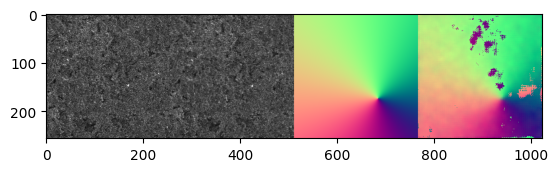

5
torch.Size([64, 2, 256, 256]) torch.Size([64, 2, 256, 256]) torch.Size([64, 2, 256, 256])
(256, 256)
Converted Y Min:  -0.4769035577774048  Max:  2.1055455207824707
Converted Pred Min:  -0.675499677658081  Max:  2.004301071166992
0 255


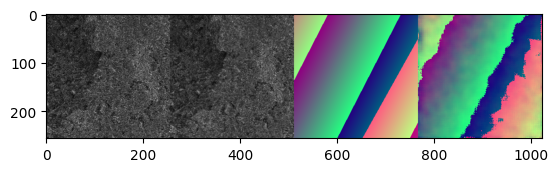

6
torch.Size([64, 2, 256, 256]) torch.Size([64, 2, 256, 256]) torch.Size([64, 2, 256, 256])
(256, 256)
Converted Y Min:  0.2383926808834076  Max:  1.0
Converted Pred Min:  0.10153752565383911  Max:  1.0725480914115906
0 255


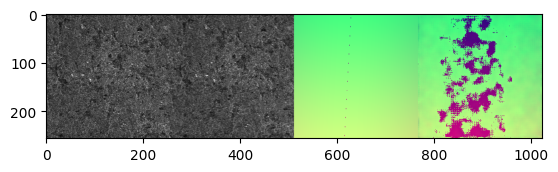

7
torch.Size([64, 2, 256, 256]) torch.Size([64, 2, 256, 256]) torch.Size([64, 2, 256, 256])
(256, 256)
Converted Y Min:  -1.070438027381897  Max:  3.42562198638916
Converted Pred Min:  -1.3153371810913086  Max:  3.4410476684570312
0 255


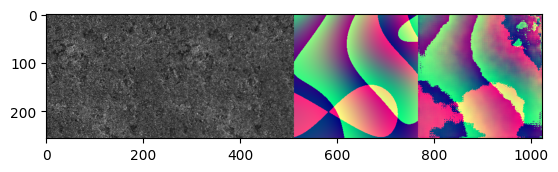

8
torch.Size([64, 2, 256, 256]) torch.Size([64, 2, 256, 256]) torch.Size([64, 2, 256, 256])
(256, 256)
Converted Y Min:  -0.49058377742767334  Max:  1.2925190925598145
Converted Pred Min:  -0.6045910120010376  Max:  1.2397170662879944
0 255


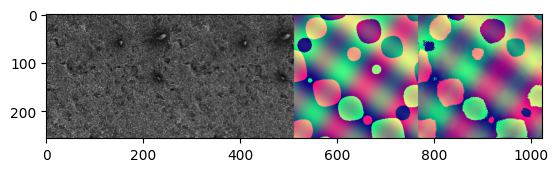

9
torch.Size([64, 2, 256, 256]) torch.Size([64, 2, 256, 256]) torch.Size([64, 2, 256, 256])
(256, 256)
Converted Y Min:  -0.5133261680603027  Max:  1.7425605058670044
Converted Pred Min:  -0.646359920501709  Max:  1.8149042129516602
0 255


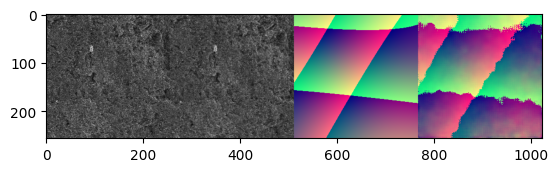

10
torch.Size([64, 2, 256, 256]) torch.Size([64, 2, 256, 256]) torch.Size([64, 2, 256, 256])
(256, 256)
Converted Y Min:  0.25984954833984375  Max:  3.1453092098236084
Converted Pred Min:  0.1363081932067871  Max:  3.1779558658599854
0 255


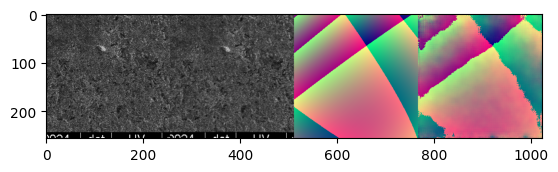

Loss: 0.060504 



In [15]:
model.eval()


test_loss= 0
i = 0
with torch.no_grad():
    for X, y in iter(validation_dataloader):
        i += 1
        if i > 10:
            break

        print(i)

        
        X, y = X.to(device), y.to(device)
        pred = model(X)
        test_loss = custom_loss(pred, y).item()

        print(X.shape, y.shape, pred.shape)

        print(X.cpu().numpy()[0][0].shape)

        
        # fig = plt.figure(figsize=(23, 5))
        # axes = fig.subplots(1, 4)

        # conver (2, 256, 256) to (256, 256, 3) and normalize
        converted_y = y[0].cpu().numpy()
        converted_y = np.vstack((converted_y, np.zeros((1, converted_y.shape[1], converted_y.shape[2]))))
        converted_y = np.transpose(converted_y, (1, 2, 0))
        converted_y = (converted_y + 1) / (2)
        print("Converted Y Min: ", converted_y.min(), " Max: ", converted_y.max())
        # converted_y = (converted_y - converted_y.min()) / (converted_y.max() - converted_y.min())

        converted_pred = pred[0].cpu().numpy()
        converted_pred = np.vstack((converted_pred, np.zeros((1, converted_pred.shape[1], converted_pred.shape[2]))))
        converted_pred = np.transpose(converted_pred, (1, 2, 0))
        converted_pred = (converted_pred + 1) / (2)
        print("Converted Pred Min: ", converted_pred.min(), " Max: ", converted_pred.max())
        # converted_pred = (converted_pred - converted_pred.min()) / (converted_pred.max() - converted_pred.min())

        base_image = np.array((X[0, 0].cpu().numpy(),)*3)
        base_image = np.transpose(base_image, (1, 2, 0))
        morph_image = np.array((X[0, 1].cpu().numpy(),)*3)
        morph_image = np.transpose(morph_image, (1, 2, 0))
        combined = np.hstack((base_image, morph_image, converted_y * 256, converted_pred * 256)).astype(np.uint8)

        print(combined.min(),combined.max())

        # plt.figure(figsizse=(20, 5))
        plt.imshow(combined)
        plt.show()

        with open(f"image_displacements{i}.txt", "w") as f:
            for y in range(TILE_SIZE):
                for x in range(TILE_SIZE):
                    u = pred[0, 0, y, x]
                    v = pred[0, 1, y, x]
                    
                    f.write(f"{x} {y} {u:.6f} {v:.6f}\n")

        # axes[0].imshow(X[0, 0].cpu().numpy())
        # axes[0].set_title("Original Image")
        # axes[1].imshow(X[0, 1].cpu().numpy())
        # axes[1].set_title("Predicted Image")
        # axes[2].imshow(converted_y)
        # axes[2].set_title("Ground Truth Image")
        # axes[3].imshow(converted_pred)
        # axes[3].set_title("Predicted Image")
        # fig.tight_layout()
        # plt.show()

print(f"Loss: {test_loss:>8f} \n")